In [1]:
import numpy as np
import torch
import lightning.pytorch as pl
import torchmetrics
import torchvision
from torchinfo import summary
from torchview import draw_graph
from IPython.display import display
import sympy as sp
sp.init_printing(use_latex=True)

import pandas as pd
import matplotlib.pyplot as plt

import urllib

In [2]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())
    print(torch.cuda.get_device_properties("cuda"))
    print("Number of devices:",torch.cuda.device_count())
    device = ("cuda")
else:
    print("Only CPU is available...")
    device = ("cpu")

NVIDIA GeForce RTX 2080 Ti
_CudaDeviceProperties(name='NVIDIA GeForce RTX 2080 Ti', major=7, minor=5, total_memory=11011MB, multi_processor_count=68)
Number of devices: 1


In [3]:
# Setup URL to Data File
url = "https://raw.githubusercontent.com/luisroque/deep-learning-articles/main/data/eng-por.txt"

data = []
with urllib.request.urlopen(url) as raw_data:
    for line in raw_data:
        data.append(line.decode("utf-8").split('\t')[0:2])
data = np.array(data)

data.shape

In [4]:
# Subset? - All of the data will take some time...
n_seq = data.shape[0]
n_seq = 100
data = data[0:n_seq]
split_point = int(data.shape[0] * 0.8) # Keep 80/20 split
np.random.shuffle(data) # In-place modification
max_length = np.max([len(i) for i in data.flatten()]) + 2 # Add start/stop

print(f"max_length = ${max_length}")
print(f"data[0] => ${data[0]}")

max_length = $23
data[0] => $['I won.' 'Eu venci.']


In [5]:
# Setup
i_to_c_eng = ['','<START>','<STOP>'] + list({char for word in data[:,0] for char in word})
c_to_i_eng = {i_to_c_eng[i]:i for i in range(len(i_to_c_eng))}
i_to_c_eng[1] = i_to_c_eng[2] = ''

i_to_c_por = ['','<START>','<STOP>'] + list({char for word in data[:,1] for char in word})
c_to_i_por = {i_to_c_por[i]:i for i in range(len(i_to_c_por))}
i_to_c_por[1] = i_to_c_por[2] = ''


In [6]:
def encode_seq(x, mapping, max_length=0):
    # String to integer
    return [mapping['<START>']] + \
    [mapping[i] for i in list(x)] + \
    [mapping['<STOP>']] + \
    [0]*(max_length-len(list(x))-2)
    
def decode_seq(x, mapping):
    # Integer-to-string
    try:
        idx = list(x).index(2) # Stop token?
    except:
        idx = len(list(x)) # No stop token found
    return ''.join([mapping[i] for i in list(x)[0:idx]])

In [7]:
data[0]


array(['I won.', 'Eu venci.'], dtype='<U184')

In [8]:
data[0,0]

'I won.'

In [9]:
temp = encode_seq(data[0,0],c_to_i_eng,max_length)

print(temp)

[1, 34, 4, 22, 33, 24, 10, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [10]:
decode_seq(temp, i_to_c_eng)

'I won.'

In [11]:
data[0,1]

'Eu venci.'

In [12]:
temp = encode_seq(data[0,1],c_to_i_por,max_length)

print(temp)

[1, 45, 21, 6, 48, 18, 32, 31, 39, 17, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [13]:
decode_seq(temp, i_to_c_por)

'Eu venci.'

In [14]:
# Setup
X = np.vstack([encode_seq(x, c_to_i_eng, max_length) for x in data[:,0]])
Y = np.vstack([encode_seq(x, c_to_i_por, max_length) for x in data[:,1]])

enc_x_train = X[:split_point]
enc_x_val = X[split_point:]
enc_x_train


array([[ 1, 34,  4, ...,  0,  0,  0],
       [ 1, 18, 11, ...,  0,  0,  0],
       [ 1, 39, 37, ...,  0,  0,  0],
       ...,
       [ 1, 18, 11, ...,  0,  0,  0],
       [ 1, 14,  9, ...,  0,  0,  0],
       [ 1, 34,  4, ...,  0,  0,  0]])

In [15]:
# Setup
dec_x_train = Y[:,0:-1][:split_point]
dec_x_val = Y[:,0:-1][split_point:]
dec_x_train

array([[ 1, 45, 21, ...,  0,  0,  0],
       [ 1, 53, 40, ...,  0,  0,  0],
       [ 1, 20,  7, ...,  0,  0,  0],
       ...,
       [ 1, 27, 41, ...,  0,  0,  0],
       [ 1, 20, 14, ...,  0,  0,  0],
       [ 1, 45, 21, ...,  0,  0,  0]])

In [16]:
dec_y_train = Y[:,1:][:split_point]
dec_y_val = Y[:,1:][split_point:]
dec_y_train

array([[45, 21,  6, ...,  0,  0,  0],
       [53, 40, 23, ...,  0,  0,  0],
       [20,  7, 21, ...,  0,  0,  0],
       ...,
       [27, 41, 31, ...,  0,  0,  0],
       [20, 14, 46, ...,  0,  0,  0],
       [45, 21,  6, ...,  0,  0,  0]])

In [17]:
print(enc_x_train.shape)
print(dec_x_train.shape)
print(dec_y_train.shape)

print("----")

print(enc_x_val.shape)
print(dec_x_val.shape)
print(dec_y_val.shape)

(80, 23)
(80, 22)
(80, 22)
----
(20, 23)
(20, 22)
(20, 22)


In [18]:
len(i_to_c_eng)

In [19]:
len(i_to_c_por)

In [20]:
enc_x_train.shape[1:]

In [21]:
class Lstm(torch.nn.Module):
    def __init__(self,
                 latent_size = 64,
                 bidirectional = False,
                 **kwargs):
        super().__init__(**kwargs)
        self.layer_norm = torch.nn.LayerNorm(latent_size)
        self.lstm_layer = torch.nn.LSTM(latent_size,
                                      latent_size // 2 if bidirectional else latent_size,
                                      bidirectional=bidirectional,
                                      batch_first=True)
    def forward(self, x):
        return x + self.lstm_layer(self.layer_norm(x))[0]

class EncoderNetwork(torch.nn.Module):
    def __init__(self,
                 num_tokens,
                 latent_size = 64, # Use something divisible by 2
                 n_layers = 4,
                 **kwargs):
        super().__init__(**kwargs)
        self.embedding = torch.nn.Embedding(num_tokens,
                                            latent_size,
                                            padding_idx=0)
        self.dropout = torch.nn.Dropout1d(0.1) # Whole token dropped
        self.lstm_layers = torch.nn.Sequential(*[
            Lstm(latent_size, True) for _ in range(n_layers)
        ])
        
    def forward(self, x):
        y = x
        y = self.embedding(y)
        y = self.dropout(y)
        y = self.lstm_layers(y)[:,-1]
        return y


In [22]:
enc_x_train[0:5].shape

In [23]:
enc_net = EncoderNetwork(num_tokens=len(i_to_c_eng))
summary(enc_net,input_data=torch.Tensor(enc_x_train[0:5]).long())

Layer (type:depth-idx)                   Output Shape              Param #
EncoderNetwork                           [5, 64]                   --
├─Embedding: 1-1                         [5, 23, 64]               2,816
├─Dropout1d: 1-2                         [5, 23, 64]               --
├─Sequential: 1-3                        [5, 23, 64]               --
│    └─Lstm: 2-1                         [5, 23, 64]               --
│    │    └─LayerNorm: 3-1               [5, 23, 64]               128
│    │    └─LSTM: 3-2                    [5, 23, 64]               25,088
│    └─Lstm: 2-2                         [5, 23, 64]               --
│    │    └─LayerNorm: 3-3               [5, 23, 64]               128
│    │    └─LSTM: 3-4                    [5, 23, 64]               25,088
│    └─Lstm: 2-3                         [5, 23, 64]               --
│    │    └─LayerNorm: 3-5               [5, 23, 64]               128
│    │    └─LSTM: 3-6                    [5, 23, 64]               25,0

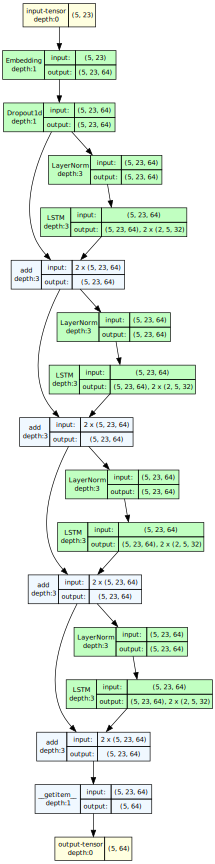

In [24]:
model_graph = draw_graph(enc_net,
                         input_data = torch.Tensor(enc_x_train[0:5]).long(),
                         device=device,
                         hide_inner_tensors=True,
                         hide_module_functions=True,
                         expand_nested=False,
                         depth=3,
                         dtypes=[torch.long])
model_graph.visual_graph

In [25]:
# Decoder Component
class DecoderNetwork(torch.nn.Module):
    def __init__(self,
                 num_tokens,
                 latent_size = 64, # Use something divisible by 2
                 n_layers = 4,
                 **kwargs):
        super().__init__(**kwargs)
        self.embedding = torch.nn.Embedding(num_tokens,
                                            latent_size,
                                            padding_idx=0)
        self.dropout = torch.nn.Dropout1d(0.1) # Whole token dropped
        self.linear = torch.nn.Linear(latent_size*2, latent_size)
        self.lstm_layers = torch.nn.Sequential(*[
            Lstm(latent_size,False) for _ in range(n_layers)
        ])
        self.output_layer = torch.nn.Linear(latent_size,
                                            num_tokens)
    
    def forward(self, x_enc, x_dec):
        y_enc = x_enc.unsqueeze(1).repeat(1,x_dec.shape[1],1)
        y_dec = self.embedding(x_dec)
        y_dec = self.dropout(y_dec)
        y = y_enc
        y = torch.concatenate([y_enc,y_dec],-1)
        y = self.linear(y)
        y = self.lstm_layers(y)
        y = self.output_layer(y)
        return y


In [26]:
enc_x_train[0:5].shape

In [27]:
dec_x_train[0:5].shape

In [28]:
# Passed through the encoder network - output tensor shape for decoder
enc_net(torch.Tensor(enc_x_train[0:5]).long().to(device)).shape

torch.Size([5, 64])

In [29]:
dec_net = DecoderNetwork(num_tokens=len(i_to_c_por))
summary(dec_net,input_data=[enc_net(torch.Tensor(enc_x_train[0:5]).long().to(device)).cpu(), torch.Tensor(dec_x_train[0:5]).long()])

Layer (type:depth-idx)                   Output Shape              Param #
DecoderNetwork                           [5, 22, 56]               --
├─Embedding: 1-1                         [5, 22, 64]               3,584
├─Dropout1d: 1-2                         [5, 22, 64]               --
├─Linear: 1-3                            [5, 22, 64]               8,256
├─Sequential: 1-4                        [5, 22, 64]               --
│    └─Lstm: 2-1                         [5, 22, 64]               --
│    │    └─LayerNorm: 3-1               [5, 22, 64]               128
│    │    └─LSTM: 3-2                    [5, 22, 64]               33,280
│    └─Lstm: 2-2                         [5, 22, 64]               --
│    │    └─LayerNorm: 3-3               [5, 22, 64]               128
│    │    └─LSTM: 3-4                    [5, 22, 64]               33,280
│    └─Lstm: 2-3                         [5, 22, 64]               --
│    │    └─LayerNorm: 3-5               [5, 22, 64]               12

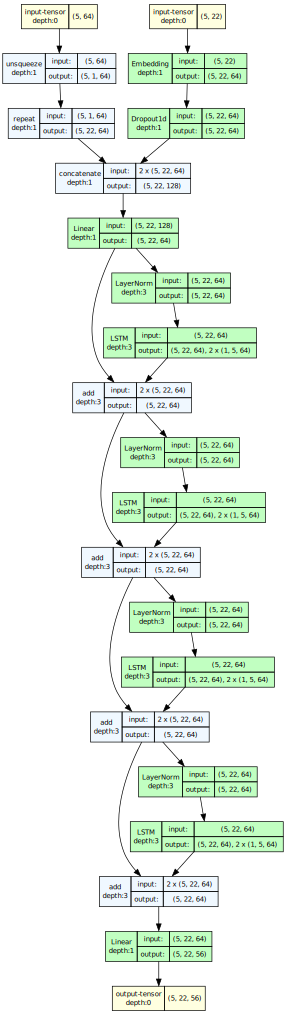

In [30]:
model_graph = draw_graph(dec_net,
                         input_data=[enc_net(torch.Tensor(enc_x_train[0:5]).long().to(device)), torch.Tensor(dec_x_train[0:5]).long()],
                         device=device,
                         hide_inner_tensors=True,
                         hide_module_functions=True,
                         expand_nested=False,
                         depth=3,
                         dtypes=[torch.long])

model_graph.visual_graph

In [31]:
class EncDecLightningModule(pl.LightningModule):
    def __init__(self,
                 output_size,
                 **kwargs):
        super().__init__(**kwargs)
        self.mc_acc = torchmetrics.classification.Accuracy(task='multiclass',
                                                           num_classes=output_size,
                                                           ignore_index=0)
        self.cce_loss = torch.nn.CrossEntropyLoss(ignore_index=0)

    def predict(self, x):
        return torch.softmax(self(x), -1)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x_enc, x_dec, y_dec = train_batch
        y_pred = self(x_enc, x_dec)
        perm = (0,-1) + tuple(range(y_pred.ndim))[1:-1]
        acc = self.mc_acc(y_pred.permute(*perm),y_dec)
        loss = self.cce_loss(y_pred.permute(*perm),y_dec)
        self.log('train_acc', acc, on_step=False, on_epoch=True)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        return loss
    
    # Validate used for Teacher Forcing
    def validation_step(self, val_batch, batch_idx):
        x_enc, x_dec, y_dec = val_batch
        y_pred = self(x_enc, x_dec)
        perm = (0,-1) + tuple(range(y_pred.ndim))[1:-1]
        acc = self.mc_acc(y_pred.permute(*perm),y_dec)
        loss = self.cce_loss(y_pred.permute(*perm),y_dec)
        self.log('val_acc', acc, on_step=False, on_epoch=True)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        return loss
    
    # Test used for Non-Teacher Forcing
    def test_step(self, test_batch, batch_idx):
        x_enc, x_dec, y_dec = test_batch
        context = self.enc_net(x_enc)
        tokens = torch.zeros_like(x_dec).long()
        tokens[:,0] = 1
        for i in range(y_dec.shape[1]-1):
            tokens[:,i+1] = self.dec_net(context, tokens).argmax(-1)[:,i]
        y_pred = self(x_enc, tokens)
        perm = (0,-1) + tuple(range(y_pred.ndim))[1:-1]
        acc = self.mc_acc(y_pred.permute(*perm),y_dec)
        loss = self.cce_loss(y_pred.permute(*perm),y_dec)
        self.log('test_acc', acc, on_step=False, on_epoch=True)
        self.log('test_loss', loss, on_step=False, on_epoch=True)
        return loss


In [32]:
class EncDecNetwork(EncDecLightningModule):
    def __init__(self,
                 num_enc_tokens,
                 num_dec_tokens,
                 latent_size = 64, # Use something divisible by 2 
                 n_layers = 4,
                 **kwargs):
        super().__init__(output_size=num_dec_tokens, **kwargs)
        self.enc_net = EncoderNetwork(num_enc_tokens,latent_size,n_layers)
        self.dec_net = DecoderNetwork(num_dec_tokens,latent_size,n_layers)
    
    def forward(self, x_enc, x_dec):
        return self.dec_net(self.enc_net(x_enc), x_dec)

In [33]:
enc_dec_net = EncDecNetwork(num_enc_tokens=len(i_to_c_eng),
                            num_dec_tokens=len(i_to_c_por))

summary(enc_dec_net,input_data=[torch.Tensor(enc_x_train[0:1]).long(),
                                torch.Tensor(dec_x_train[0:1]).long()])

Layer (type:depth-idx)                   Output Shape              Param #
EncDecNetwork                            [1, 22, 56]               --
├─EncoderNetwork: 1-1                    [1, 64]                   --
│    └─Embedding: 2-1                    [1, 23, 64]               2,816
│    └─Dropout1d: 2-2                    [1, 23, 64]               --
│    └─Sequential: 2-3                   [1, 23, 64]               --
│    │    └─Lstm: 3-1                    [1, 23, 64]               25,216
│    │    └─Lstm: 3-2                    [1, 23, 64]               25,216
│    │    └─Lstm: 3-3                    [1, 23, 64]               25,216
│    │    └─Lstm: 3-4                    [1, 23, 64]               25,216
├─DecoderNetwork: 1-2                    [1, 22, 56]               --
│    └─Embedding: 2-4                    [1, 22, 64]               3,584
│    └─Dropout1d: 2-5                    [1, 22, 64]               --
│    └─Linear: 2-6                       [1, 22, 64]           

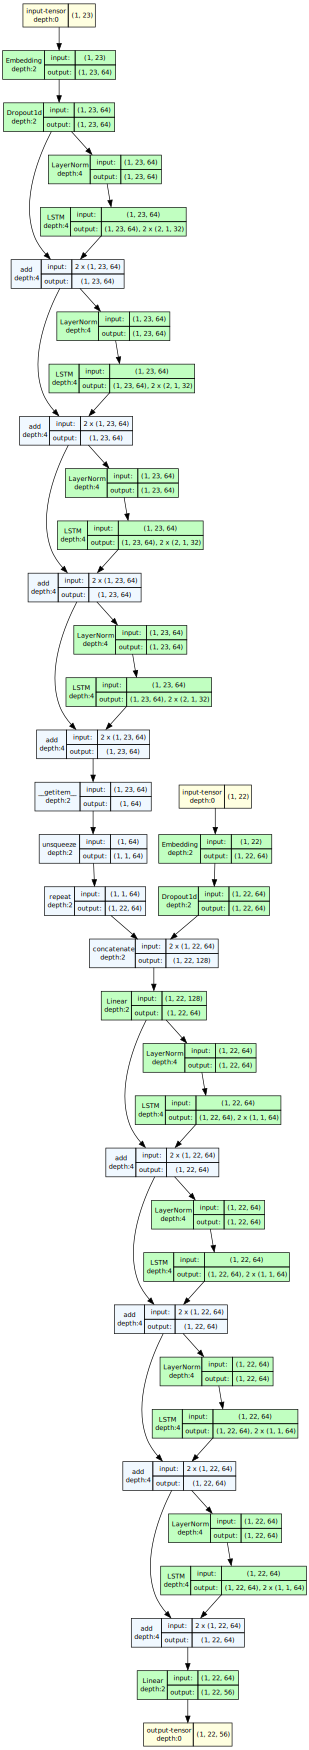

In [34]:
model_graph = draw_graph(enc_dec_net,
                         input_data=[torch.Tensor(enc_x_train[0:1]).long(),
                                     torch.Tensor(dec_x_train[0:1]).long()], 
                         device=device,
                         hide_inner_tensors=True,
                         hide_module_functions=True, 
                         expand_nested=False, 
                         depth=4, 
                         dtypes=[torch.long])

model_graph.visual_graph

In [35]:
batch_size = 20
xy_train = torch.utils.data.DataLoader(list(zip(torch.Tensor(enc_x_train).long(),
                                                torch.Tensor(dec_x_train).long(),
                                                torch.Tensor(dec_y_train).long())), 
                                       shuffle=True, 
                                       batch_size=batch_size, 
                                       num_workers=8)

xy_val = torch.utils.data.DataLoader(list(zip(torch.Tensor(enc_x_val).long(), 
                                              torch.Tensor(dec_x_val).long(),
                                              torch.Tensor(dec_y_val).long())), 
                                     shuffle=False, 
                                     batch_size=batch_size, 
                                     num_workers=8)

/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [36]:
logger = pl.loggers.CSVLogger("lightning_logs", 
                              name="Open_Lab_4",
                              version="demo-0")

In [37]:
trainer = pl.Trainer(logger=logger, max_epochs=300,
                     enable_progress_bar=True,
                     log_every_n_steps=0,
                     enable_checkpointing=False, 
                     callbacks=[pl.callbacks.TQDMProgressBar(refresh_rate=50)])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [38]:
trainer.validate(enc_dec_net, xy_val)

/opt/conda/lib/python3.11/site-packages/lightning/fabric/loggers/csv_logs.py:195: UserWarning: Experiment logs directory lightning_logs/Open_Lab_4/demo-0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │   0.011695906519889832    │
│         val_loss          │     4.102419853210449     │
└───────────────────────────┴───────────────────────────┘

[{'val_acc': 0.011695906519889832, 'val_loss': 4.102419853210449}]

In [39]:
trainer.test(enc_dec_net, xy_val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │   0.011695906519889832    │
│         test_loss         │     4.031111240386963     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.011695906519889832, 'test_loss': 4.031111240386963}]

In [40]:
trainer.fit(enc_dec_net, xy_train, xy_val) 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params
------------------------------------------------
0 | mc_acc   | MulticlassAccuracy | 0     
1 | cce_loss | CrossEntropyLoss   | 0     
2 | enc_net  | EncoderNetwork     | 103 K 
3 | dec_net  | DecoderNetwork     | 149 K 
------------------------------------------------
252 K     Trainable params
0         Non-trainable params
252 K     Total params
1.011     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.


In [41]:
results = pd.read_csv(logger.log_dir+"/metrics.csv")
results

,val_acc,val_loss,epoch,step,test_acc,test_loss,train_acc,train_loss
0,0.011696,4.102420,0,0,NaN,NaN,NaN,NaN
1,NaN,NaN,0,0,0.011696,4.031111,NaN,NaN
2,0.169591,3.615376,0,3,NaN,NaN,NaN,NaN
3,NaN,NaN,0,3,NaN,NaN,0.075708,3.885664
4,0.210526,3.268421,1,7,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
597,NaN,NaN,297,1191,NaN,NaN,0.909654,0.210854
598,0.584795,2.761594,298,1195,NaN,NaN,NaN,NaN
599,NaN,NaN,298,1195,NaN,NaN,0.917589,0.188617
600,0.602339,2.748387,299,1199,NaN,NaN,NaN,NaN


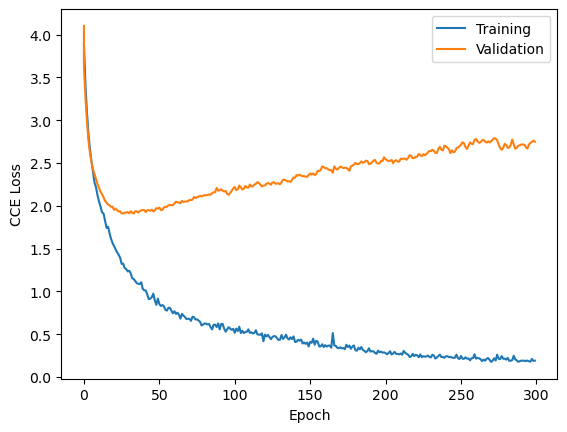

In [42]:
plt.plot(results["epoch"][np.logical_not(np.isnan(results["train_loss"]))],
         results["train_loss"][np.logical_not(np.isnan(results["train_loss"]))],
         label="Training")

plt.plot(results["epoch"][np.logical_not(np.isnan(results["val_loss"]))], 
         results["val_loss"][np.logical_not(np.isnan(results["val_loss"]))], 
         label="Validation")

plt.legend() 
plt.ylabel("CCE Loss") 
plt.xlabel("Epoch") 
plt.show()

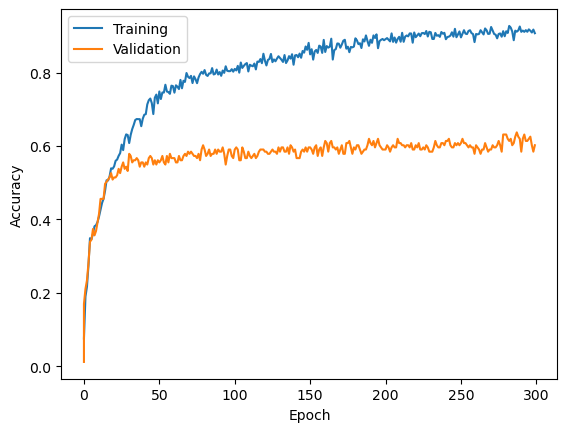

In [43]:
plt.plot(results["epoch"][np.logical_not(np.isnan(results["train_acc"]))], 
         results["train_acc"][np.logical_not(np.isnan(results["train_acc"]))], 
         label="Training")
plt.plot(results["epoch"][np.logical_not(np.isnan(results["val_acc"]))], 
         results["val_acc"][np.logical_not(np.isnan(results["val_acc"]))], 
         label="Validation")

plt.legend() 
plt.ylabel("Accuracy")
plt.xlabel("Epoch") 
plt.show()

In [44]:
print("")
print("Validation accuracy:", *["%.8f"%(x) for x in results['val_acc'][np.logical_not(np.isnan(results["val_acc"]))]])
print("")
print("")


Validation accuracy: 0.01169591 0.16959064 0.21052632 0.23391815 0.28070176 0.33918127 0.34502923 0.37426901 0.35672516 0.36842105 0.39181286 0.41520467 0.45614034 0.45614034 0.45614034 0.49707603 0.50292397 0.50877196 0.51461989 0.52631581 0.50877196 0.51461989 0.51461989 0.52046782 0.53801167 0.52631581 0.54385966 0.55555558 0.53801167 0.54385966 0.53216374 0.57894737 0.57309943 0.55555558 0.56140351 0.56140351 0.56725144 0.56140351 0.54385966 0.55555558 0.55555558 0.54385966 0.55555558 0.54970759 0.56725144 0.57309943 0.56725144 0.54970759 0.56140351 0.54970759 0.56140351 0.55555558 0.56140351 0.57309943 0.55555558 0.54970759 0.57309943 0.55555558 0.57894737 0.56725144 0.56725144 0.56725144 0.55555558 0.55555558 0.57309943 0.56140351 0.56140351 0.57309943 0.57894737 0.57309943 0.58479530 0.57894737 0.58479530 0.57894737 0.57309943 0.57309943 0.56725144 0.57894737 0.56140351 0.59064329 0.60233921 0.59064329 0.57309943 0.57894737 0.59064329 0.57309943 0.57894737 0.57894737 0.59064329

In [47]:
results = trainer.test(enc_dec_net, xy_val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.3684210479259491     │
│         test_loss         │     6.280609607696533     │
└───────────────────────────┴───────────────────────────┘

In [46]:
print("Test Accuracy:",results[0]['test_acc'])

Test Accuracy: 0.3684210479259491


In [48]:
results

[{'test_acc': 0.3684210479259491, 'test_loss': 6.280609607696533}]